# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))

In [2]:
from enum import Enum
class Scenario(Enum):
    single_object_single_robot = 0
    double_object_single_robot = 1
    single_object_dual_robot = 2
    assembly_3_piece = 3

In [3]:
current_scenario = Scenario.single_object_single_robot

In [4]:
if current_scenario in [Scenario.single_object_dual_robot, Scenario.assembly_3_piece]:
    from pkg.ur10_dual import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_collision_items_dict
else:
    from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_collision_items_dict
from pkg.constraint_graph import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True

In [5]:
graph = ConstraintGraph(urdf_path = URDF_PATH, joint_names = JOINT_NAMES, link_names = LINK_NAMES)
graph.set_collision_items(get_collision_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=False))

# Single object

In [6]:
if current_scenario == Scenario.single_object_single_robot:
    graph.add_collision_items("world", 
                              [GeoBox((0.5,-0.2,0.050), (0.1,0.1,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1)),
                               GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1)),
                               GeoBox((0.7,0.0,0.2), (0.7,0.05,0.4), name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
                               GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
                               GeoBox((0.4,0.4,0.3), (0.1,0.1,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1),
                                      collision=False)])
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,0], link_name="tool0", direction=[0,0,1])
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal', _type=PlaceFrame, point=(0.4,0.4,0.3+5e-4), link_name="world", orientation=[0,0,0])

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p","floor"))

    graph.update_handles()

# Double object

In [7]:
if current_scenario == Scenario.double_object_single_robot:
    graph.add_collision_items("world", [
        GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1)),
        GeoBox((0.7,0.0,0.2), (0.7,0.05,0.4), name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((0.5,-0.2,0.050), (0.1,0.1,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1)),
        GeoBox((0.4,-0.3,0.050), (0.1,0.1,0.1), name="box2", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.8,0.3,1)),
        GeoBox((0.4,0.4,0.15), (0.3,0.3,0.3), name="stepper1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((-0.1,-0.4,0.15), (0.3,0.3,0.3), name="stepper2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((0.4,0.4,0.3), (0.2,0.2,1e-3), name="goal1_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.0,0.0,0.8,1),
               collision=False),
        GeoBox((-0.1,-0.4,0.3), (0.2,0.2,1e-3), name="goal2_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.8,0.0,1),
               collision=False)])
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,1e-3], link_name="tool0", direction=[0,0,1])
    
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p", "floor"), hexahedral=True)
    graph.register_object('box2', _type=BoxAction, binding=("bottom_p", "floor"), hexahedral=True)
    graph.register_binder(name='box11', _type=PlacePlane, object_name="box1", point=[0,0,0.05], direction=[0,0,1])
    graph.register_binder(name='box12', _type=PlacePlane, object_name="box1", point=[0.05,0,0.05], direction=[0,0,1])
    graph.register_binder(name='box2', _type=PlacePlane, point=[0,0,0.05], direction=[0,0,1])
    graph.register_binder(name='goal1', _type=PlacePlane, point=(0.4,0.4,0.3), link_name="world", direction=[0,0,1])
    graph.register_binder(name='goal2', _type=PlacePlane, point=(-0.1,-0.4,0.3+5e-4), link_name="world", direction=[0,0,1])

    graph.update_handles()

# Single object Dual robot

In [8]:
if current_scenario == Scenario.single_object_dual_robot:
    graph.add_collision_items("world", [
        GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="tool0_1", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
        GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper2", link_name="tool0_2", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
        GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
        GeoBox((-1,0.0,2.5), (0.1,10.0,5), name="wall_back", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
        GeoBox((0,0.0,0.10), (2.0,0.03,0.20), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((0,0.0,1.4), (2.0,0.03,2), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
        GeoBox((0.5,-0.2,0.050), (0.1,0.1,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1)),
        GeoBox((0.4,0.4,0.0), (0.2,0.2,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.0,0.0,0.8,1),
               collision=False)])
#         GeoBox((-1,0.0,2.5), (0.1,10.0,5), name="wall_back", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
#         GeoBox((0,0.0,0.0), (2.0,0.03,0.01), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # no wall
#         GeoBox((0,0.0,2), (2.0,0.03,0.01), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # no wall
#         GeoBox((0,0.0,0.10), (2.0,0.03,0.20), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # lower wall
#         GeoBox((0,0.0,2), (2.0,0.03,0.01), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # lower wall
#         GeoBox((0,0.0,0.10), (2.0,0.03,0.20), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # 40cm
#         GeoBox((0,0.0,1.6), (2.0,0.03,2), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # 40cm
#         GeoBox((0,0.0,0.10), (2.0,0.03,0.20), name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # 20cm
#         GeoBox((0,0.0,1.4), (2.0,0.03,2), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)), # 20cm
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0_1", direction=[0,0,1])
    graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0_2", direction=[0,0,1])
    
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal1', _type=PlacePlane, point=(0.4,0.4,0.0+5e-4), link_name="world", direction=[0,0,1])
    graph.register_object('box1', _type=BoxAction, binding=("bottom_p", "floor"), hexahedral=True)

    graph.update_handles()

# Assembly 3 piece

In [9]:
if current_scenario == Scenario.assembly_3_piece:
    graph.add_collision_items("world", [
        GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="tool0_1", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
        GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper2", link_name="tool0_2", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
        GeoBox((0,0,-0.005), (10,10,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
        GeoBox((-1,0.0,2.5), (0.1,10.0,5), name="wall_back", link_name="world", urdf_content=graph.urdf_content, color=(1,1,1,1)),
        GeoBox((0.5,0.0,0.050), (0.1,0.4,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1)),
        GeoBox((0.5,0.3,0.050), (0.1,0.1,0.1), name="box2", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.3,0.3,1)),
        GeoBox((0.5,-0.3,0.050), (0.1,0.1,0.1), name="box3", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.3,0.3,1)),
        GeoBox((0.5,-1.1,0.0), (0.2,0.2,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.0,0.0,0.8,1),
               collision=False)])
#        GeoBox((0.4,0.4,0.15), (0.3,0.3,0.3), name="stepper1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
    
    graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0_1", direction=[0,0,1])
    graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,5e-2], link_name="tool0_2", direction=[0,0,1])
    
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal1', _type=PlacePlane, point=(0.5,-1.1,0.0+5e-4), link_name="world", direction=[0,0,1])
    graph.register_binder(name='asm1', _type=PlaceFrame, object_name="box1", point=[0,0.15,0.05], orientation=(0,0,0))
    graph.register_binder(name='asm2', _type=PlaceFrame, object_name="box1", point=[0,-0.15,0.05], orientation=(0,0,0))

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p", "floor"))
    graph.register_object('box2', _type=BoxAction, binding=("bottom_p", "floor"))
    graph.register_object('box3', _type=BoxAction, binding=("bottom_p", "floor"))

    graph.update_handles()

# vis

In [10]:
# if current_scenario == Scenario.single_object_dual_robot:
#     graph.add_collision_items("world", [
#         GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.8,0.8,1)),
#         GeoSegment((0.3,-0.25,0.21), 'Y', 0.5, 0.01, name="wall1", link_name="world", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
#         GeoSegment((0.3,0,0.21), 'X', 0.2, 0.01, name="wallx", link_name="world", urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1)),
#         GeoBox((0.4,0.0,0.1), (0.5,1.0,0.2), name="wall2", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1)),
#         GeoBox((0.5,-0.2,0.050), (0.1,0.1,0.1), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), display=False),
#         GeoBox((0.4,0.4,0.15), (0.3,0.3,0.3), name="stepper1", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), display=False),
#         GeoBox((0.4,0.4,0.3), (0.2,0.2,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.0,0.0,0.8,1),
#                collision=False, display=False)])
    
#     graph.register_binder(name='vac1', _type=VacuumTool, point=[0,0,1e-3], link_name="tool0_1", direction=[0,0,1])
#     graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,1e-3], link_name="tool0_2", direction=[0,0,1])
    
#     graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
#     graph.register_binder(name='goal1', _type=PlacePlane, point=(0.4,0.4,0.3+5e-4), link_name="world", direction=[0,0,1])

#     graph.register_object('box1', _type=BoxAction, binding=("bottom_p", "floor"))

#     graph.update_handles()

# Set RVIZ

In [11]:
graph.set_simulation(nWSR=50, regularization_factor= 1e-1)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
publication OK
publication OK
publication OK
publication OK
publication OK


# build

In [12]:
graph.build_graph()

# Search Graph (Single object)

In [13]:
if current_scenario == Scenario.single_object_single_robot:
    graph.search_graph_ordered_mp(initial_state = \
                                  State((('box1','bottom_p','floor'),), 
                                        {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                  goal_state = State((('box1','bottom_f','goal'),), None, None),
                                  search_num=200, display=False, N_agents = 12,
                                  terminate_on_first = True, tree_margin = 0,
                                  depth_margin = 2, joint_motion_num=50, 
                                  **dict(N=300, dt=0.01, vel_conv=1e-2, err_conv=1e-3))


1. success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 / edepth: 2/2 / 0.29 s (10)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac1'),):(('box1', 'top_p', 'vac1'),)

2. fail - Goal cost:1->0 / Init cost:1->2 / branching: 1-> / edepth: 2/2 / 0.73 s (0)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'bottom_f', 'goal'),):
register depth_buffer = 3.0
current depth = 3.0

3. success - Goal cost:1->1 / Init cost:1->1 / branching: 1->2 / edepth: 3/3 / 1.08 s (1)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):(('box1', 'top_p', 'vac1'),)

5. success - Goal cost:1->1 / Init cost:1->1 / branching: 1->3 / edepth: 3/3 / 1.15 s (3)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):(('box1', 'top_p', 'vac1'),)

4. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 1.22 s (2)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):

6. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 1.25 s 


29. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 2.38 s (4)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):

26. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 2.45 s (0)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):

31. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 2.47 s (5)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):

27. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 2.56 s (1)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):

30. fail - Goal cost:1->1 / Init cost:1->1 / branching: 1-> / edepth: 3/3 / 2.56 s (3)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):

34. success - Goal cost:1->1 / Init cost:1->1 / branching: 1->9 / edepth: 3/3 / 2.59 s (10)
node: (('box1', 'top_p', 'vac1'),)->(('box1', 'top_p', 'vac1'),):(('box1', 'top_p', 'vac1'),)

33. fail - Goal cost:1->1 / Init cost:1->1

# Search Graph (Double object)

In [14]:
if current_scenario == Scenario.double_object_single_robot:
    graph.search_graph_ordered_mp(initial_state = State((('box1','bottom_p','floor'),('box2','bottom_p','floor')),
                                                        {'box1': [0.5,-0.2,0.05,0,0,0,1], 'box2': [0.4,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                  goal_state = State((('box1','bottom_p','goal1'),('box2','bottom_p','goal2')), None, None),
                                  search_num=1000, display=False, N_agents = 12,
                                  terminate_on_first = False, tree_margin = 2,
                                  depth_margin = 3, joint_motion_num=10,
                                  **dict(N=200, dt=0.01, vel_conv=1e-2, err_conv=1e-3))

# Search Graph (Single object Dual robot)

In [15]:
if current_scenario == Scenario.single_object_dual_robot:
    graph.search_graph_ordered_mp(initial_state = State((('box1','bottom_p','floor'),),
                                                        {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                  goal_state = State((('box1','bottom_p','goal1'),), None, None),
                                  search_num=3000, display=False, N_agents = 12,
                                  terminate_on_first = True, tree_margin = 0,
                                  depth_margin = 2, joint_motion_num=10,
                                  expand_depth_on_thread = True, **dict(N=200, dt=0.01, vel_conv=1e-2, err_conv=5e-4))

# Assembly 3 piece

In [16]:
if current_scenario == Scenario.assembly_3_piece:
    init_state = State(*(graph.get_object_state()+(ZERO_JOINT_POSE,)))
    goal_state = State(*((('box1', 'bottom_p', 'goal1'),
                          ('box2', 'bottom_f', 'asm1'),
                          ('box3', 'bottom_f', 'asm2')),None, None))
    graph.search_graph_ordered_mp(initial_state = init_state,
                                  goal_state = goal_state,
                                  search_num=500, display=False, N_agents = 8,
                                  terminate_on_first = True, tree_margin = 1,
                                  depth_margin = 2, joint_motion_num=10,
                                  expand_depth_on_thread = True, **dict(N=200, dt=0.01, vel_conv=1e-2, err_conv=5e-4))

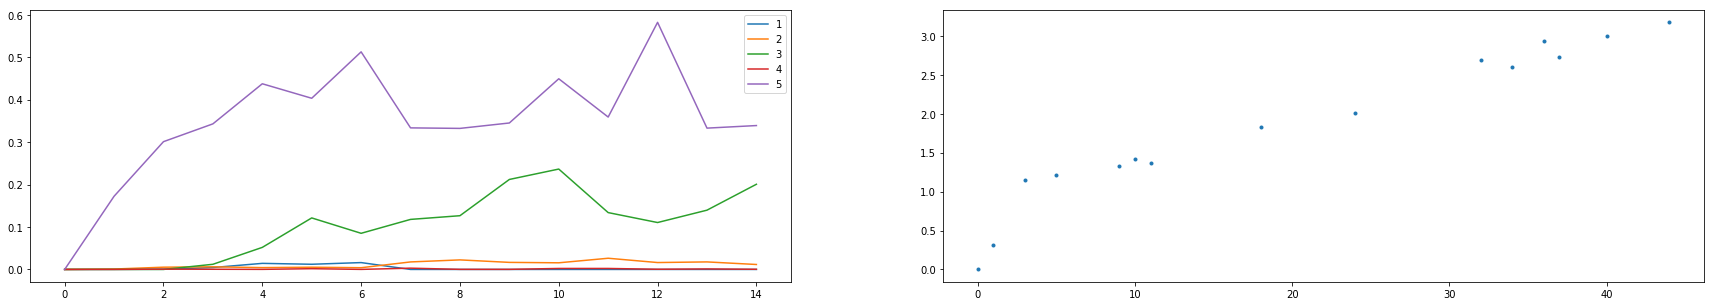

In [17]:
time_table = np.array(graph.time_table)
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(time_table[:,0])
plt.plot(time_table[:,1])
plt.plot(time_table[:,2])
plt.plot(time_table[:,3])
plt.plot(time_table[:,4])
plt.legend(['1','2','3','4','5'])
plt.subplot(1,2,2)
plt.plot(graph.itor_vec, graph.time_vec,'.')

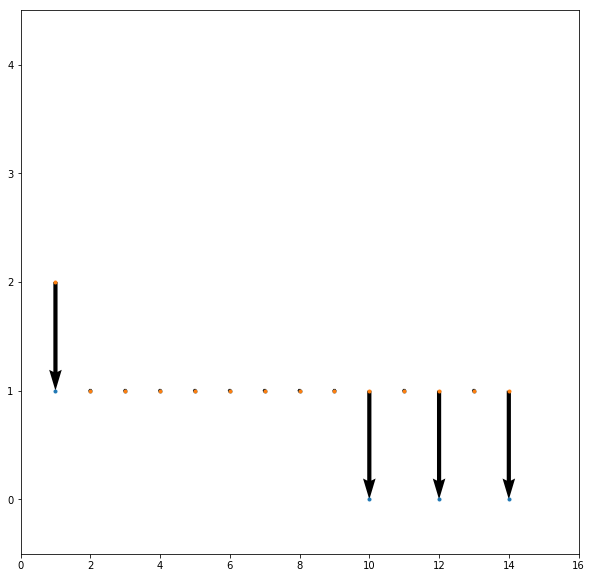

In [18]:
graph.quiver_snodes()

# Replay schedule

In [19]:
schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted, range(len(schedule_sorted))):
    graph.simulate_transition(graph.snode_vec[0].state, graph.snode_vec[0].state, display=True, N=100, dt=0.01, vel_conv=1e-2, err_conv=1e-3)
    timer.sleep(1)
#     try:
    e = graph.replay(schedule, N=300, dt=0.01, vel_conv=5e-2, err_conv=1e-2)
#     except Exception as e:
#         print(e)

[0, 1, 3, 10]
[0, 1, 4, 12]
[0, 1, 6, 14]

--------------------
1-(('box1', 'top_p', 'vac1'),)

--------------------
3-(('box1', 'top_p', 'vac1'),)

--------------------
10-(('box1', 'bottom_f', 'goal'),)

--------------------
1-(('box1', 'top_p', 'vac1'),)

--------------------
4-(('box1', 'top_p', 'vac1'),)

--------------------
12-(('box1', 'bottom_f', 'goal'),)

--------------------
1-(('box1', 'top_p', 'vac1'),)

--------------------
6-(('box1', 'top_p', 'vac1'),)

--------------------
14-(('box1', 'bottom_f', 'goal'),)


In [ ]:
# e = graph.replay(schedule, N=1500, dt=0.002, vel_conv=1e-2, err_conv=5e-3)

# Visualize

In [ ]:
from pkg.graph_visualize import VisualGraph

In [ ]:
g = VisualGraph()

# for node, neighbor in graph.node_dict.items(): # for visualizing all
#     g.add_node(node,neighbor) # for visualizing all

for node, neighbor in graph.valid_node_dict.items():
    g.add_node(node,neighbor) # for visualizing all

# for idx in schedule: # for visualizing schedule
#     snode = graph.snode_vec[idx]
#     leafs = [(leaf, graph.snode_vec[leaf]) for leaf in snode.leafs if leaf in schedule] # for visualizing schedule
#     g.add_node("%d-"%idx+str(snode.state.node),["%d-"%i_l+str(leaf.state.node) for i_l, leaf in leafs]) # for visualizing schedule

In [ ]:
g.draw().render()
g.draw(True)

In [ ]:
g = VisualGraph()

for node, neighbor in graph.node_dict.items(): # for visualizing all
    g.add_node(node,neighbor) # for visualizing all

# for node, neighbor in graph.valid_node_dict.items():
#     leafs = ["{}-{}".format(leaf,graph.goal_cost_dict[leaf]) for leaf in neighbor] # for visualizing valid-only
#     g.add_node("{}-{}".format(node,graph.goal_cost_dict[node]), leafs) # for visualizing valid-only

# for idx in schedule: # for visualizing schedule
#     snode = graph.snode_vec[idx]
#     leafs = [(leaf, graph.snode_vec[leaf]) for leaf in snode.leafs if leaf in schedule] # for visualizing schedule
#     g.add_node("%d-"%idx+str(snode.state.node),["%d-"%i_l+str(leaf.state.node) for i_l, leaf in leafs]) # for visualizing schedule

In [ ]:
g.draw().render()
g.draw(True)

In [ ]:
def namer(node):
    if node[0][2] == 'floor':
        return 'free | free'
    if node[0][2] == 'vac1':
        return 'grasp | free'
    if node[0][2] == 'vac2':
        return 'free | grasp'
    if node[0][2] == 'goal1':
        return 'free | place'

In [ ]:
g = VisualGraph()

# for node, neighbor in graph.node_dict.items(): # for visualizing all
#     g.add_node(node,neighbor) # for visualizing all

for node, neighbor in graph.valid_node_dict.items():
#     leafs = ["{}-{}".format(leaf,graph.goal_cost_dict[leaf]) for leaf in neighbor] # for visualizing valid-only
    leafs = [namer(leaf) for leaf in neighbor] # for visualizing valid-only
    g.add_node(namer(node), leafs) # for visualizing valid-only


In [ ]:
g = VisualGraph()

for node, neighbor in graph.node_dict.items(): # for visualizing all
    g.add_node(namer(node), [namer(nd) for nd in neighbor]) # for visualizing all

# for node, neighbor in graph.valid_node_dict.items():
# #     leafs = ["{}-{}".format(leaf,graph.goal_cost_dict[leaf]) for leaf in neighbor] # for visualizing valid-only
#     leafs = [namer(leaf) for leaf in neighbor] # for visualizing valid-only
#     g.add_node(namer(node), leafs) # for visualizing valid-only


In [ ]:
g.draw().render()
g.draw(True)

# Test time

In [ ]:
if current_scenario == Scenario.single_object_dual_robot:
    times = []
    iters = []
#    N_vec = [1,2,4,6,8,12,16]
    N_vec = [8]
#     N_vec = [1,2,4,6,8]
    for n_agent in N_vec:
        time_vec = []
        iter_vec = []
        for _ in range(10):
#         for _ in range(2):
            t1 =timer.time()
            graph.search_graph_ordered_mp(initial_state = State((('box1','bottom_p','floor'),),
                                                                {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE),
                                          goal_state = State((('box1','bottom_p','goal1'),), None, None),
                                          search_num=3000, display=False, N_agents = n_agent,
                                          terminate_on_first = True, tree_margin = 0,
                                          depth_margin = 2, joint_motion_num=10,
                                          expand_depth_on_thread = True, **dict(N=200, dt=0.01, vel_conv=1e-2, err_conv=1e-3))
            time_vec += [timer.time()-t1]
            iter_vec += [graph.itor]
        times += [time_vec]
        iters += [iter_vec]
        

In [ ]:
print(np.round(np.mean(times,axis=1),2))
print(np.round(np.median(times,axis=1),2))

In [ ]:
for ll in iters:
    for ii in range(len(ll)):
        ll[ii] = ll[ii].value

In [ ]:
plt.figure(figsize=(30,3))
plt.subplot(1,3,1)
plot_band(plt, N_vec, times, title="time")
plt.subplot(1,3,2)
plot_band(plt, N_vec, iters, title="iteration")
plt.subplot(1,3,3)
plot_band(plt, N_vec, np.divide(iters, times), title="iter/s")
np.save("iteration_count/iterations", iters)
np.save("iteration_count/times", times)
np.save("iteration_count/numbers", N_vec)

In [ ]:
plt.plot(N_vec,np.mean(times,axis=1))
plt.plot(N_vec,np.median(times,axis=1))

In [ ]:
iters[0][0].value

In [ ]:
plt.plot(N_vec,np.mean(iters,axis=1))
plt.plot(N_vec,np.median(iters,axis=1))

In [ ]:
folder = "iteration_count/"
iters = np.load(folder+"iterations.npy")
times = np.load(folder+"times.npy")
N_vec = np.load(folder+"numbers.npy")
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plot_band(plt, N_vec, times, title="time")
plt.grid()
plt.subplot(1,3,2)
plot_band(plt, N_vec, iters, title="iteration")
plt.grid()
plt.subplot(1,3,3)
plot_band(plt, N_vec, np.divide(iters, times), title="iter/s")

In [ ]:
folder = "iteration_count/bak/"
iters = np.load(folder+"iterations.npy")
times = np.load(folder+"times.npy")
N_vec = np.load(folder+"numbers.npy")
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plot_band(plt, N_vec, times, title="time")
plt.grid()
plt.subplot(1,3,2)
plot_band(plt, N_vec, iters, title="iteration")
plt.grid()
plt.subplot(1,3,3)
plot_band(plt, N_vec, np.divide(iters, times), title="iter/s")

# simulate transitions

In [ ]:
print(graph.snode_vec[52].state)

In [ ]:
sidx = 18
schedule = graph.snode_vec[sidx].parents+[sidx]
schedule

In [ ]:
self = graph
display=False
error_skip=1e-4
lock=False
err_conv=1e-4
kwargs = dict(N=N, dt=dt, vel_conv=1e-2)
        
if from_state is not None:
    pos_start = from_state.Q
    self.set_object_state(from_state)

additional_constraints = ""
binding_list = []
if to_state.node is not None:
    for bd0, bd1 in zip(from_state.node, to_state.node):
        if bd0[2] != bd1[2]:
            additional_constraints += self.binder_dict[bd1[2]].make_constraints(self.object_dict[bd1[0]], bd1[1])
            binding_list += [bd1]
        else:
            assert bd0[1] == bd1[1] , "impossible transition"

if additional_constraints=="" and to_state.Q is not None and np.sum(np.abs(np.subtract(to_state.Q,from_state.Q)))>1e-2:
#             print('set joint constraint')
    kwargs.update(dict(additional_constraints=make_joint_constraints(joint_names=self.joint_names), 
                       inp_lbl=['target_%s'%jname for jname in self.joint_names], 
                       inp=list(to_state.Q)
                      ))                 
else:
    kwargs.update(dict(additional_constraints=additional_constraints)
                 )

init_text = get_init_text()

e = set_simulate(init_text, initial_jpos=np.array(pos_start), err_conv=err_conv, **kwargs)
            
            
if from_state is not None:
    self.set_object_state(from_state)
if display:
    if len(e.POS)>1:
        show_motion(e.POS, self.marker_list, self.pub, self.joints, self.joint_names, error_skip=1e-4)
if hasattr(e, 'error') and e.error<err_conv:
    success = True
    for bd in binding_list:
        self.rebind(bd, e.joint_dict_last)

else:
    success = False
node, obj_pos_dict = self.get_object_state()
end_state = State(node, obj_pos_dict, list(e.POS[-1]))

In [ ]:
success

In [ ]:
kk = 2
from_state = graph.snode_vec[schedule[kk]].state
# to_state = graph.snode_vec[schedule[kk+1]].state
to_state = State((('box1', 'top_p', 'vac2'), ('box2', 'bottom_f', 'asm1'), ('box3', 'bottom_f', 'asm2')), None, None)
# to_state = from_state
# from_state = State(*((('box1', 'top_p', 'vac2'), ('box2', 'bottom_f', 'asm1'), ('box3', 'bottom_f', 'asm2')), 
#                      {'box1': [ 0.,    0.,    0.1,   0.63,  0.78,  0.,   -0.  ], 
#                       'box3': [-0.1,  -0.02, -0.,    0.63,  0.78,  0.,   -0.  ], 
#                       'box2': [ 0.1,   0.02, -0.,    0.63,  0.78,  0.,    0.  ]}, 
#                      [-0.83, -1.16,  1.6,   0.79,  1.32, -0.36,  0.5,  -0.89,  1.3,   0.82,  1.83, -0.03]))
# to_state = State((('box1', 'bottom_p', 'goal1'), ('box2', 'bottom_f', 'asm1'), ('box3', 'bottom_f', 'asm2')), None, None)
N = 300
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

In [ ]:
print(end_state)

In [ ]:
e.error

In [ ]:
e.OUTP_LBL

In [ ]:
e.OUTP.shape

In [ ]:
plt.plot(e.OUTP[:,0])

In [ ]:
print(from_state)
print(to_state)
print(end_state)

In [ ]:
len(e.POS)

In [ ]:
idx_end = np.where(np.any(e.VEL!=0,axis=1))[0]

In [ ]:
idx_end

In [ ]:
plt.plot(e.VEL)

In [ ]:
plt.plot(e.POS)

In [ ]:
schedule[1]

In [ ]:
from_state_bak = State(*(graph.get_object_state()+(e.POS[-1],)))

In [ ]:
from_state_bak.node

In [ ]:
from_state = from_state_bak.copy()

In [ ]:
to_state = State((('box1', 'bottom_p', 'goal2'), ('box2', 'bottom_p', 'box1')),None, None)

In [ ]:
N = 300
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

In [ ]:
from_state = end_state
to_state = State((('box1', 'back_p', 'vac1'), ('box2', 'bottom_p', 'box1')),None, None)
# to_state = end_state.copy()
# to_state.Q = ZERO_JOINT_POSE

In [ ]:
N = 1000
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-2, err_conv=6e-3)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=6e-3)
print(succ)

In [ ]:
e.error

In [ ]:
print(end_state)

In [ ]:
from_state = end_state
to_state = from_state.copy()
to_state.Q = ZERO_JOINT_POSE

In [ ]:
N = 300
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

In [ ]:
graph.binder_dict

In [ ]:
from_state = State((('box1', 'top_p', 'box2'), ('box2', 'bottom_p', 'vac1')),
                   {'box1': (0, 0, 0.2, 0.0, -0.0, 0.0, 1),
                    'box2': (0, 0, 0.1, 0.0, -0.0, -0.0, 1)}, ZERO_JOINT_POSE)

In [ ]:
to_state = State((('box1', 'top_p', 'box2'), ('box2', 'bottom_p', 'vac1')),
                   {'box1': (0, 0, 0.2, 0.0, -0.0, 0.0, 1),
                    'box2': (0, 0, 0.1, 0.0, -0.0, -0.0, 1)}, [ 0.        , -np.pi/2,  np.pi/2,  0.        ,  0.        , 0.]        )

In [ ]:
from_state = State((('box1', 'bottom_p', 'box2'), ('box2', 'bottom_p', 'vac1')), {'box1': [-0.03, -0.39 , 0.45, 0.,   -0. ,   0.56,  0.83], 'box2': [-0.1,  -0.4 ,  0.35 , 0. ,  -0. ,  -0.34 , 0.94]}, [-2.08, -2.13,  2.22, -1.66, -1.57,  0.03])
to_state = State((('box1', 'bottom_p', 'box2'), ('box2', 'bottom_p', 'vac1')), {'box1': [-0.03, -0.39,  0.45,  0.,   -0. ,   0.56,  0.83], 'box2': [-0.1  ,-0.4 ,  0.35  ,0.,   -0. ,  -0.34 , 0.94]}, ZERO_JOINT_POSE)

In [ ]:
## N = 100
dt = 0.02

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt)
print(succ)

In [ ]:
N = 300
dt = 0.01

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

In [ ]:
from_state = State((('box1','bottom_p','floor'),), 
                      {'box1': [0.5,-0.2,0.05,0,0,0,1]}, ZERO_JOINT_POSE
                     )
to_state = State((('box1','top_p','vac1'),), None, None)
N = 100
dt = 0.02

t1 = timer.time()
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=False, N=N, dt=dt)
t2 = timer.time()
print("%.2f ms"%((t2-t1)*1000))
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, N=N, dt=dt)
print(succ)

In [ ]:
from_state = end_state
to_state = State((('box1','top_p','vac1'),), 
                      None, ZERO_JOINT_POSE)
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True)
print(succ)

In [ ]:
from_state = end_state
to_state = State((('box1','bottom_f','goal'),), None, None)
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True)
print(succ)

In [ ]:
from_state = end_state
to_state = end_state.copy()
to_state.Q = ZERO_JOINT_POSE
e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True)

In [ ]:
graph.binder_dict['box2'].object

In [ ]:
graph.object_dict['box2'].object

# delete all

In [ ]:
for mkr in marker_list:
    mkr.delete()

# Plotting (using the Bokeh library to provide interactive plots)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from etasl_py.bokehplots import plotv

output_notebook()
print("positions : ")
plotv(e.TIME,e.POS,e.POS_LBL)
print("velocities : ")
plotv(e.TIME,e.VEL,e.POS_LBL)
print("outputs : ")
plotv(e.TIME,e.OUTP,e.OUTP_LBL)

In [ ]:
!urdf_to_graphiz $(rospack find etasl_py_examples)/robots/ur10_robot.urdf
from graphviz import Source
Source.from_file('ur10.gv')